## Thanks to [@Abhishek Thakur](https://www.kaggle.com/abhishek) youtube channel for this wonderful video and kernal.

### [Bengali.AI: Handwritten Grapheme Classification Using PyTorch (Part-1)](https://www.youtube.com/watch?v=8J5Q4mEzRtY) 

### [Bengali.AI: Handwritten Grapheme Classification Using PyTorch (Part-2)](https://www.youtube.com/watch?v=uZalt-weQMM&t=3478s)

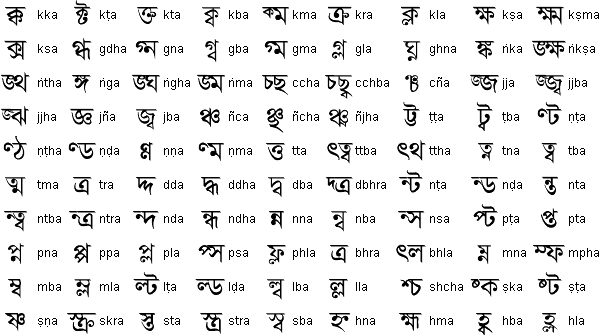

### Used model
* ResNet34 


In [ ]:
%%writefile create_folds.py

import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if __name__ == "__main__":
    df = pd.read_csv("../input/train.csv")
    print(df.head())
    df.loc[:, 'kfold'] = -1

    df = df.sample(frac=1).reset_index(drop=True)

    X = df.image_id.values
    y = df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values

    mskf = MultilabelStratifiedKFold(n_splits=5)

    for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
        print("TRAIN: ", trn_, "VAL: ", val_)
        df.loc[val_, "kfold"] = fold

    print(df.kfold.value_counts())
    df.to_csv("../input/train_folds.csv", index=False)

In [ ]:
%%writefile create_image_pickles.py

import pandas as pd
import joblib
import glob
from tqdm import tqdm

if __name__ == "__main__":
    files = glob.glob("../input/train_*.parquet")
    for f in files:
        df = pd.read_parquet(f, engine='fastparquet')
        image_ids = df.image_id.values
        df = df.drop("image_id", axis=1)
        image_array = df.values
        for j, image_id in tqdm(enumerate(image_ids), total=len(image_ids)):
            joblib.dump(image_array[j, :], f"../input/image_pickles/{image_id}.pkl")


In [ ]:
%%writefile dataset.py

import pandas as pd
import albumentations
import joblib
import numpy as np
import torch

from PIL import Image

class BengaliDatasetTrain:
    def __init__(self, folds, img_height, img_width, mean, std):
        df = pd.read_csv("../input/train_folds.csv")
        df = df[["image_id", "grapheme_root", "vowel_diacritic", "consonant_diacritic", "kfold"]]

        df = df[df.kfold.isin(folds)].reset_index(drop=True)
        
        self.image_ids = df.image_id.values
        self.grapheme_root = df.grapheme_root.values
        self.vowel_diacritic = df.vowel_diacritic.values
        self.consonant_diacritic = df.consonant_diacritic.values

        if len(folds) == 1:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                #albumentations.ShiftScaleRotate(shift_limit=0.0625,
                #                                scale_limit=0.1, 
                #                                rotate_limit=5,
                #                                p=0.9),
                albumentations.Normalize(mean, std, always_apply=True)
            ])


    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = joblib.load(f"../input/image_pickles/{self.image_ids[item]}.pkl")
        image = image.reshape(137, 236).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "image": torch.tensor(image, dtype=torch.float),
            "grapheme_root": torch.tensor(self.grapheme_root[item], dtype=torch.long),
            "vowel_diacritic": torch.tensor(self.vowel_diacritic[item], dtype=torch.long),
            "consonant_diacritic": torch.tensor(self.consonant_diacritic[item], dtype=torch.long)
        }


In [ ]:
%%writefile models.py

import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        
        self.l0 = nn.Linear(512, 168)
        self.l1 = nn.Linear(512, 11)
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2


In [ ]:
%%writefile model_dispatcher.py

import models

MODEL_DISPATCHER = {
    "resnet34": models.ResNet34
}  

In [ ]:
%%writefile train.py

import os
import ast
import torch
import torch.nn as nn
import numpy as np
import sklearn.metrics

from model_dispatcher import MODEL_DISPATCHER
from dataset import BengaliDatasetTrain
from tqdm import tqdm
from pytorchtools import EarlyStopping


DEVICE = "cuda"
TRAINING_FOLDS_CSV = os.environ.get("TRAINING_FOLDS_CSV")

IMG_HEIGHT = int(os.environ.get("IMG_HEIGHT"))
IMG_WIDTH = int(os.environ.get("IMG_WIDTH"))
EPOCHS = int(os.environ.get("EPOCHS"))

TRAIN_BATCH_SIZE = int(os.environ.get("TRAIN_BATCH_SIZE"))
TEST_BATCH_SIZE = int(os.environ.get("TEST_BATCH_SIZE"))

MODEL_MEAN = ast.literal_eval(os.environ.get("MODEL_MEAN"))
MODEL_STD = ast.literal_eval(os.environ.get("MODEL_STD"))

TRAINING_FOLDS = ast.literal_eval(os.environ.get("TRAINING_FOLDS"))
VALIDATION_FOLDS = ast.literal_eval(os.environ.get("VALIDATION_FOLDS"))
BASE_MODEL = os.environ.get("BASE_MODEL")



def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, 'f'total {final_score}, y {y.shape}')
    
    return final_score


def loss_fn(outputs, targets):
    o1, o2, o3 = outputs
    t1, t2, t3 = targets
    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o2, t2)
    l3 = nn.CrossEntropyLoss()(o3, t3)
    return (l1 + l2 + l3) / 3



def train(dataset, data_loader, model, optimizer):
    model.train()
    final_loss = 0
    counter = 0
    final_outputs = []
    final_targets = []

    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        counter = counter + 1
        image = d["image"]
        grapheme_root = d["grapheme_root"]
        vowel_diacritic = d["vowel_diacritic"]
        consonant_diacritic = d["consonant_diacritic"]

        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)
        
        print(image.shape)

        optimizer.zero_grad()
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        final_loss += loss

        o1, o2, o3 = outputs
        t1, t2, t3 = targets
        final_outputs.append(torch.cat((o1,o2,o3), dim=1))
        final_targets.append(torch.stack((t1,t2,t3), dim=1))

        #if bi % 10 == 0:
        #    break
    final_outputs = torch.cat(final_outputs)
    final_targets = torch.cat(final_targets)

    print("=================Train=================")
    macro_recall_score = macro_recall(final_outputs, final_targets)
    
    return final_loss/counter , macro_recall_score



def evaluate(dataset, data_loader, model):
    with torch.no_grad():
        model.eval()
        final_loss = 0
        counter = 0
        final_outputs = []
        final_targets = []
        for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
            counter = counter + 1
            image = d["image"]
            grapheme_root = d["grapheme_root"]
            vowel_diacritic = d["vowel_diacritic"]
            consonant_diacritic = d["consonant_diacritic"]

            image = image.to(DEVICE, dtype=torch.float)
            grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
            vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
            consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)

            outputs = model(image)
            targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
            loss = loss_fn(outputs, targets)
            final_loss += loss

            o1, o2, o3 = outputs
            t1, t2, t3 = targets
            #print(t1.shape)
            final_outputs.append(torch.cat((o1,o2,o3), dim=1))
            final_targets.append(torch.stack((t1,t2,t3), dim=1))
        
        final_outputs = torch.cat(final_outputs)
        final_targets = torch.cat(final_targets)

        print("=================Train=================")
        macro_recall_score = macro_recall(final_outputs, final_targets)

    return final_loss/counter , macro_recall_score



def main():
    model = MODEL_DISPATCHER[BASE_MODEL](pretrained=True)
    model.to(DEVICE)

    train_dataset = BengaliDatasetTrain(
        folds=TRAINING_FOLDS,
        img_height = IMG_HEIGHT,
        img_width = IMG_WIDTH,
        mean = MODEL_MEAN,
        std = MODEL_STD
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size= TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

    valid_dataset = BengaliDatasetTrain(
        folds=VALIDATION_FOLDS,
        img_height = IMG_HEIGHT,
        img_width = IMG_WIDTH,
        mean = MODEL_MEAN,
        std = MODEL_STD
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size= TEST_BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=5, 
                                                            factor=0.3,verbose=True)

    early_stopping = EarlyStopping(patience=5, verbose=True)

    #if torch.cuda.device_count() > 1:
    #    model = nn.DataParallel(model)

    best_score = -1

    print("FOLD : ", VALIDATION_FOLDS[0] )
    
    for epoch in range(1, EPOCHS+1):

        train_loss, train_score = train(train_dataset,train_loader, model, optimizer)
        val_loss, val_score = evaluate(valid_dataset, valid_loader, model)

        scheduler.step(val_loss)

        

        if val_score > best_score:
            best_score = val_score
            torch.save(model.state_dict(), f"{BASE_MODEL}_fold{VALIDATION_FOLDS[0]}.pth")

        epoch_len = len(str(EPOCHS))
        print_msg = (f'[{epoch:>{epoch_len}}/{EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_score: {train_score:.5f} ' +
                     f'valid_loss: {val_loss:.5f} ' +
                     f'valid_score: {val_score:.5f}'
                    )
        
        print(print_msg)

        early_stopping(val_score, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break


if __name__ == "__main__":
    main()

In [ ]:
%%writefile run.sh

export IMG_HEIGHT=137
export IMG_WIDTH=236
export EPOCHS=50
export TRAIN_BATCH_SIZE=64
export TEST_BATCH_SIZE=64
export MODEL_MEAN="(0.485, 0.456, 0.406)"
export MODEL_STD="(0.229, 0.224, 0.225)"
export BASE_MODEL="resnet34"
export TRAINING_FOLDS_CSV="../input/train_folds.csv"


export TRAINING_FOLDS="(0,1,2,3)"
export VALIDATION_FOLDS="(4,)"
python3 train.py

export TRAINING_FOLDS="(0,1,2,4)"
export VALIDATION_FOLDS="(3,)"
python3 train.py

export TRAINING_FOLDS="(0,1,3,4)"
export VALIDATION_FOLDS="(2,)"
python3 train.py

export TRAINING_FOLDS="(0,2,3,4)"
export VALIDATION_FOLDS="(1,)"
python3 train.py

export TRAINING_FOLDS="(1,2,3,4)"
export VALIDATION_FOLDS="(0,)"
python3 train.py


# Inference

In [ ]:
import sys
pt_models = "../input/pretrained-models/pretrained-models.pytorch-master/"
sys.path.insert(0, pt_models)
import pretrainedmodels

In [ ]:
#when internet is off
# %%capture
# !pip install /kaggle/input/output/albumentations-0.4.3/albumentations-0.4.3
# !pip install /kaggle/input/output/imgaug-0.2.6/imgaug-0.2.6
# !pip install /kaggle/input/output/opencv_python-4.2.0.32-cp36-cp36m-manylinux1_x86_64.whl

#for internet when on
#!pip install albumentations

In [ ]:
import glob
import torch
import albumentations
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image
import joblib
import torch.nn as nn
from torch.nn import functional as F

In [ ]:

MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)
IMG_HEIGHT = 137
IMG_WIDTH = 236
DEVICE="cuda"

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        
        self.l0 = nn.Linear(512, 168)
        self.l1 = nn.Linear(512, 11)
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2


In [ ]:
class BengaliDatasetTest:
    def __init__(self, df, img_height, img_width, mean, std):
        
        self.image_ids = df.image_id.values
        self.img_arr = df.iloc[:, 1:].values

        self.aug = albumentations.Compose([
            albumentations.Resize(img_height, img_width, always_apply=True),
            albumentations.Normalize(mean, std, always_apply=True)
        ])


    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = self.img_arr[item, :]
        img_id = self.image_ids[item]
        
        image = image.reshape(137, 236).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        

        return {
            "image": torch.tensor(image, dtype=torch.float),
            "image_id": img_id
        }

In [ ]:
def model_predict():
    g_pred, v_pred, c_pred = [], [], []
    img_ids_list = [] 
    
    for file_idx in range(4):
        df = pd.read_parquet(f"../input/bengaliai-cv19/test_image_data_{file_idx}.parquet")

        dataset = BengaliDatasetTest(df=df,
                                    img_height=IMG_HEIGHT,
                                    img_width=IMG_WIDTH,
                                    mean=MODEL_MEAN,
                                    std=MODEL_STD)

        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size= TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=4
        )

        for bi, d in enumerate(data_loader):
            image = d["image"]
            img_id = d["image_id"]
            image = image.to(DEVICE, dtype=torch.float)

            g, v, c = model(image)
            #g = np.argmax(g.cpu().detach().numpy(), axis=1)
            #v = np.argmax(v.cpu().detach().numpy(), axis=1)
            #c = np.argmax(c.cpu().detach().numpy(), axis=1)

            for ii, imid in enumerate(img_id):
                g_pred.append(g[ii].cpu().detach().numpy())
                v_pred.append(v[ii].cpu().detach().numpy())
                c_pred.append(c[ii].cpu().detach().numpy())
                img_ids_list.append(imid)
        
    return g_pred, v_pred, c_pred, img_ids_list

In [ ]:
model = ResNet34(pretrained=False)
TEST_BATCH_SIZE = 32

final_g_pred = []
final_v_pred = []
final_c_pred = []
final_img_ids = []

for i in range(5):
    model.load_state_dict(torch.load(f"../input/resnet34weights/resnet34_fold{i}.pth"))
    model.to(DEVICE)
    model.eval()
    g_pred, v_pred, c_pred, img_ids_list = model_predict()
    
    final_g_pred.append(g_pred)
    final_v_pred.append(v_pred)
    final_c_pred.append(c_pred)
    if i == 0:
        final_img_ids.extend(img_ids_list)

In [ ]:
img_ids_list

In [ ]:
final_g = np.argmax(np.mean(np.array(final_g_pred), axis=0), axis=1)
final_v = np.argmax(np.mean(np.array(final_v_pred), axis=0), axis=1)
final_c = np.argmax(np.mean(np.array(final_c_pred), axis=0), axis=1)

In [ ]:
final_img_ids

In [ ]:
predictions = []
for ii, imid in enumerate(final_img_ids):
    predictions.append((f"{imid}_grapheme_root", final_g[ii]))
    predictions.append((f"{imid}_vowel_diacritic", final_v[ii]))
    predictions.append((f"{imid}_consonant_diacritic", final_c[ii]))

In [ ]:
sub = pd.DataFrame(predictions, columns=["row_id", "target"])

In [ ]:
sub

In [ ]:
sub.to_csv("submission.csv", index=False)